In [1]:
import keras
import keras.backend as K
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, CuDNNLSTM, CuDNNGRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Conv2DTranspose, Embedding, Multiply, Activation

from functools import partial

from collections import defaultdict

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import isolearn.io as isoio
import isolearn.keras as isol

import matplotlib.pyplot as plt

import tensorflow as tf

from keras.backend.tensorflow_backend import set_session

import pandas as pd

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

class MySequence :
    def __init__(self) :
        self.dummy = 1

keras.utils.Sequence = MySequence

import isolearn.keras as iso

from sequence_logo_helper_protein import plot_protein_logo, letterAt_protein

class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            val : key for key, val in channel_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            if max_nt == 1 :
                seq += self.decode_map[argmax_nt]
            else :
                seq += "0"

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        encoding = np.array(encoding_mat[row_index, :].todense()).reshape(-1, 4)
        return self.decode(encoding)

class NopTransformer(iso.ValueTransformer) :
    
    def __init__(self, n_classes) :
        super(NopTransformer, self).__init__('nop', (n_classes, ))
        
        self.n_classes = n_classes
    
    def transform(self, values) :
        return values
    
    def transform_inplace(self, values, transform) :
        transform[:] = values
    
    def transform_inplace_sparse(self, values, transform_mat, row_index) :
        transform_mat[row_index, :] = np.ravel(values)


Using TensorFlow backend.


In [2]:
#Re-load cached dataframe (shuffled)

dataset_name = "coiled_coil_binders"

experiment = "baker_big_set_5x_negatives"

pair_df = pd.read_csv("pair_df_" + experiment + "_in_shuffled.csv", sep="\t")

print("len(pair_df) = " + str(len(pair_df)))

print(pair_df.head())

#Generate training and test set indexes
valid_set_size = 0.0005
test_set_size = 0.0995

data_index = np.arange(len(pair_df), dtype=np.int)

train_index = data_index[:-int(len(pair_df) * (valid_set_size + test_set_size))]
valid_index = data_index[train_index.shape[0]:-int(len(pair_df) * test_set_size)]
test_index = data_index[train_index.shape[0] + valid_index.shape[0]:]

print('Training set size = ' + str(train_index.shape[0]))
print('Validation set size = ' + str(valid_index.shape[0]))
print('Test set size = ' + str(test_index.shape[0]))


len(pair_df) = 890124
   Unnamed: 0                                       monomer_id_1  \
0           0  redesigned_closed_6_6_9_9middlesbobby_1_4_S_01...   
1           1  redesigned_closed_6_8_9_9middlesbobby_1_4_S_40...   
2           2  redesigned_closed_6_6_9_10middlesbobby_1_4_S_1...   
3           3  redesigned_closed_5_7_9_9middlesbobby_1_1_S_43...   
4           4  redesigned_closed_6_6_8_10middlesbobby_1_5_S_2...   

                                        monomer_id_2  \
0  redesigned_closed_6_6_8_10middlesbobby_1_5_S_2...   
1  redesigned_closed_5_7_8_10middlesbobby_1_2_S_0...   
2  redesigned_closed_6_6_9_9middlesbobby_1_4_S_07...   
3  redesigned_closed_5_6_9_9middlesbobby_1_1_S_25...   
4  redesigned_closed_6_6_8_9middlesbobby_1_5_S_16...   

                                         amino_seq_1  \
0  SEKDLLRLNREILEEIERIQKDLEELLERAERDAEGGLEELEKLVR...   
1  SEKEVMKEQIRLIRENIKAQEEILRLLKELERKGVDKEVEEVIKRI...   
2  DEEEILKILEENLRIQREIDRIHEEQVKALERITRRREDREEIEKL...   
3  STEDI

In [3]:
#Calculate sequence lengths

pair_df['amino_seq_1_len'] = pair_df['amino_seq_1'].str.len()
pair_df['amino_seq_2_len'] = pair_df['amino_seq_2'].str.len()


In [4]:
#Initialize sequence encoder

seq_length = 81

residue_map = {'D': 0, 'E': 1, 'V': 2, 'K': 3, 'R': 4, 'L': 5, 'S': 6, 'T': 7, 'N': 8, 'H': 9, 'A': 10, 'I': 11, 'G': 12, 'P': 13, 'Q': 14, 'Y': 15, 'W': 16, 'M': 17, 'F': 18, '#': 19}

encoder = IdentityEncoder(seq_length, residue_map)


In [5]:
#Construct data generators

class CategoricalRandomizer :
    
    def __init__(self, case_range, case_probs) :
        self.case_range = case_range
        self.case_probs = case_probs
        self.cases = 0
        
    def get_random_sample(self, index=None) :
        if index is None :
            return self.cases
        else :
            return self.cases[index]
    
    def generate_random_sample(self, batch_size=1, data_ids=None) :
        self.cases = np.random.choice(self.case_range, size=batch_size, replace=True, p=self.case_probs)

def get_amino_seq(row, index, flip_randomizer, homodimer_randomizer, max_seq_len=seq_length) :
    
    is_flip = True if flip_randomizer.get_random_sample(index=index) == 1 else False
    is_homodimer = True if homodimer_randomizer.get_random_sample(index=index) == 1 else False
    
    amino_seq_1, amino_seq_2 = row['amino_seq_1'], row['amino_seq_2']
    if is_flip :
        amino_seq_1, amino_seq_2 = row['amino_seq_2'], row['amino_seq_1']
    if is_homodimer and row['interacts'] < 0.5 :
        amino_seq_2 = amino_seq_1
    
    return amino_seq_1, amino_seq_2

flip_randomizer = CategoricalRandomizer(np.arange(2), np.array([0.5, 0.5]))
homodimer_randomizer = CategoricalRandomizer(np.arange(2), np.array([0.95, 0.05]))

batch_size = 32

data_gens = {
    gen_id : iso.DataGenerator(
        idx,
        { 'df' : pair_df },
        batch_size=(idx.shape[0] // batch_size) * batch_size,
        inputs = [
            {
                'id' : 'amino_seq_1',
                'source_type' : 'dataframe',
                'source' : 'df',
                #'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: (get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[0] + "#" * seq_length)[:seq_length],
                'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[0],
                'encoder' : IdentityEncoder(seq_length, residue_map),
                'dim' : (1, seq_length, len(residue_map)),
                'sparsify' : False
            },
            {
                'id' : 'amino_seq_2',
                'source_type' : 'dataframe',
                'source' : 'df',
                #'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: (get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[1] + "#" * seq_length)[:seq_length],
                'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[1],
                'encoder' : IdentityEncoder(seq_length, residue_map),
                'dim' : (1, seq_length, len(residue_map)),
                'sparsify' : False
            },
            {
                'id' : 'amino_seq_1_len',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: len(get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[0]),
                'encoder' : lambda t: t,
                'dim' : (1,),
                'sparsify' : False
            },
            {
                'id' : 'amino_seq_2_len',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: len(get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[1]),
                'encoder' : lambda t: t,
                'dim' : (1,),
                'sparsify' : False
            }
        ],
        outputs = [
            {
                'id' : 'interacts',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index: row['interacts'],
                'transformer' : NopTransformer(1),
                'dim' : (1,),
                'sparsify' : False
            }
        ],
        randomizers = [flip_randomizer, homodimer_randomizer],
        shuffle = True
    ) for gen_id, idx in [('train', train_index), ('valid', valid_index), ('test', test_index)]
}


In [6]:
#Load data matrices

[x_1_train, x_2_train, l_1_train, l_2_train], [y_train] = data_gens['train'][0]
[x_1_val, x_2_val, l_1_val, l_2_val], [y_val] = data_gens['test'][0]

print("x_1_train.shape = " + str(x_1_train.shape))
print("x_2_train.shape = " + str(x_2_train.shape))
print("x_1_val.shape = " + str(x_1_val.shape))
print("x_2_val.shape = " + str(x_2_val.shape))

print("l_1_train.shape = " + str(l_1_train.shape))
print("l2_train.shape = " + str(l_2_train.shape))
print("l_1_val.shape = " + str(l_1_val.shape))
print("l2_val.shape = " + str(l_2_val.shape))

print("y_train.shape = " + str(y_train.shape))
print("y_val.shape = " + str(y_val.shape))


x_1_train.shape = (801088, 1, 81, 20)
x_2_train.shape = (801088, 1, 81, 20)
x_1_val.shape = (88544, 1, 81, 20)
x_2_val.shape = (88544, 1, 81, 20)
l_1_train.shape = (801088, 1)
l2_train.shape = (801088, 1)
l_1_val.shape = (88544, 1)
l2_val.shape = (88544, 1)
y_train.shape = (801088, 1)
y_val.shape = (88544, 1)


In [7]:
#Define sequence templates

sequence_templates = [
    '$' * i + '@' * (seq_length - i)
    for i in range(seq_length+1)
]

sequence_masks = [
    np.array([1 if sequence_templates[i][j] == '$' else 0 for j in range(len(sequence_templates[i]))])
    for i in range(seq_length+1)
]


In [8]:
#Load cached dataframe (shuffled)

dataset_name = "coiled_coil_binders"

experiment = "coiled_coil_binders_alyssa"

data_df = pd.read_csv(experiment + ".csv", sep="\t")

print("len(data_df) = " + str(len(data_df)))

test_df = data_df.copy().reset_index(drop=True)

batch_size = 32
test_df = test_df.iloc[:(len(test_df) // batch_size) * batch_size].copy().reset_index(drop=True)

print("len(test_df) = " + str(len(test_df)))

print(test_df.head())


len(data_df) = 481
len(test_df) = 480
                                        monomer_id_1  \
0  redesigned_closed_5_7_9_9middlesbobby_1_1_S_39...   
1  redesigned_closed_6_6_9_9middlesbobby_1_4_S_07...   
2  redesigned_closed_6_6_9_9middlesbobby_1_4_S_08...   
3  redesigned_closed_5_6_9_10middlesscott_1_1_S_3...   
4  redesigned_closed_6_6_9_10middlesbobby_1_4_S_1...   

                                        monomer_id_2  \
0  redesigned_closed_5_7_9_9middlesbobby_1_1_S_39...   
1  redesigned_closed_6_6_9_9middlesbobby_1_4_S_07...   
2  redesigned_closed_6_6_9_9middlesbobby_1_4_S_08...   
3  redesigned_closed_5_6_9_10middlesscott_1_1_S_3...   
4  redesigned_closed_6_6_9_10middlesbobby_1_4_S_1...   

                                         amino_seq_1  \
0  DEEELLKLIEDLLKSNKELLDLSKKNLRLLRELVRERNMDDTALRK...   
1  SEKELLELLRELIEDLDRDVKLLRRNVDLHRRVAREGMREELIKKS...   
2  SEEERITEIVKRVEELLRRYEELVKEYKRVLEELRRELREEEQKEL...   
3  SDEEELDEIIKRSEEVMREVEEIDKRVEDIVRKAAKEGASELVKRS...   
4  TVKEL

In [9]:
#Construct test data

batch_size = 32

test_gen = iso.DataGenerator(
    np.arange(len(test_df), dtype=np.int),
    { 'df' : test_df },
    batch_size=(len(test_df) // batch_size) * batch_size,
    inputs = [
        {
            'id' : 'amino_seq_1',
            'source_type' : 'dataframe',
            'source' : 'df',
            #'extractor' : lambda row, index: (row['amino_seq_1'] + "#" * seq_length)[:seq_length],
            'extractor' : lambda row, index: row['amino_seq_1'],
            'encoder' : IdentityEncoder(seq_length, residue_map),
            'dim' : (1, seq_length, len(residue_map)),
            'sparsify' : False
        },
        {
            'id' : 'amino_seq_2',
            'source_type' : 'dataframe',
            'source' : 'df',
            #'extractor' : lambda row, index: row['amino_seq_2'] + "#" * seq_length)[:seq_length],
            'extractor' : lambda row, index: row['amino_seq_2'],
            'encoder' : IdentityEncoder(seq_length, residue_map),
            'dim' : (1, seq_length, len(residue_map)),
            'sparsify' : False
        },
        {
            'id' : 'amino_seq_1_len',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : lambda row, index: len(row['amino_seq_1']),
            'encoder' : lambda t: t,
            'dim' : (1,),
            'sparsify' : False
        },
        {
            'id' : 'amino_seq_2_len',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : lambda row, index: len(row['amino_seq_2']),
            'encoder' : lambda t: t,
            'dim' : (1,),
            'sparsify' : False
        }
    ],
    outputs = [
        {
            'id' : 'interacts',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : lambda row, index: row['interacts'],
            'transformer' : NopTransformer(1),
            'dim' : (1,),
            'sparsify' : False
        }
    ],
    randomizers = [],
    shuffle = False
)

#Load data matrices

[x_1_test, x_2_test, l_1_test, l_2_test], [y_test] = test_gen[0]

print("x_1_test.shape = " + str(x_1_test.shape))
print("x_2_test.shape = " + str(x_2_test.shape))
print("l_1_test.shape = " + str(l_1_test.shape))
print("l_2_test.shape = " + str(l_2_test.shape))

print("y_test.shape = " + str(y_test.shape))


x_1_test.shape = (480, 1, 81, 20)
x_2_test.shape = (480, 1, 81, 20)
l_1_test.shape = (480, 1)
l_2_test.shape = (480, 1)
y_test.shape = (480, 1)


In [10]:
#Load predictor model

def get_shared_model() :
    
    gru_1 = Bidirectional(CuDNNGRU(64, return_sequences=False), merge_mode='concat')
    
    drop_1 = Dropout(0.25)

    def shared_model(inp) :

        gru_1_out = gru_1(inp)
        
        drop_1_out = drop_1(gru_1_out)

        return drop_1_out
    
    return shared_model

shared_model = get_shared_model()

#Inputs
res_1 = Input(shape=(seq_length, 19 + 1))
res_2 = Input(shape=(seq_length, 19 + 1))

#Outputs
true_interacts = Input(shape=(1,))

#Interaction model definition
dense_out_1 = shared_model(res_1)
dense_out_2 = shared_model(res_2)

layer_dense_pair_1 = Dense(128, activation='relu')
dense_out_pair = layer_dense_pair_1(Concatenate(axis=-1)([dense_out_1, dense_out_2]))

pred_interacts = Dense(1, activation='sigmoid', kernel_initializer='zeros')(dense_out_pair)

predictor = Model(
    inputs=[
        res_1,
        res_2
    ],
    outputs=pred_interacts
)

predictor.load_weights('saved_models/ppi_rnn_baker_big_set_5x_negatives_classifier_symmetric_drop_25_5x_negatives_balanced_partitioned_data_epoch_10.h5', by_name=True)
predictor.trainable = False

predictor.compile(
    optimizer=keras.optimizers.SGD(lr=0.1),
    loss='mean_squared_error'
)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
#Generate (original) predictions

pred_train = predictor.predict([x_1_train[:, 0, ...], x_2_train[:, 0, ...]], batch_size=32, verbose=True)
pred_val = predictor.predict([x_1_val[:, 0, ...], x_2_val[:, 0, ...]], batch_size=32, verbose=True)
pred_test = predictor.predict([x_1_test[:, 0, ...], x_2_test[:, 0, ...]], batch_size=32, verbose=True)

pred_train = np.concatenate([1. - pred_train, pred_train], axis=1)
pred_val = np.concatenate([1. - pred_val, pred_val], axis=1)
pred_test = np.concatenate([1. - pred_test, pred_test], axis=1)


480/480 [==============================] - 0s 735us/step


In [12]:
#Make two-channel targets

y_train = np.concatenate([1. - y_train, y_train], axis=1)
y_val = np.concatenate([1. - y_val, y_val], axis=1)
y_test = np.concatenate([1. - y_test, y_test], axis=1)


In [13]:
from keras.layers import Input, Dense, Multiply, Flatten, Reshape, Conv2D, MaxPooling2D, GlobalMaxPooling2D, Activation
from keras.layers import BatchNormalization
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import regularizers
from keras import backend as K

import tensorflow as tf
import numpy as np

from keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints

class InstanceNormalization(Layer):
    def __init__(self, axes=(1, 2), trainable=True, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.axes = axes
        self.trainable = trainable
    def build(self, input_shape):
        self.beta  = self.add_weight(name='beta',shape=(input_shape[-1],),
                                     initializer='zeros',trainable=self.trainable)
        self.gamma = self.add_weight(name='gamma',shape=(input_shape[-1],),
                                     initializer='ones',trainable=self.trainable)
    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, self.axes, keep_dims=True)
        return tf.nn.batch_normalization(inputs, mean, variance, self.beta, self.gamma, 1e-6)

def bernoulli_sampling (prob):
    """ Sampling Bernoulli distribution by given probability.

    Args:
    - prob: P(Y = 1) in Bernoulli distribution.

    Returns:
    - samples: samples from Bernoulli distribution
    """  

    n, x_len, y_len, d = prob.shape
    samples = np.random.binomial(1, prob, (n, x_len, y_len, d))

    return samples

class INVASE():
    """INVASE class.

    Attributes:
    - x_train: training features
    - y_train: training labels
    - model_type: invase or invase_minus
    - model_parameters:
      - actor_h_dim: hidden state dimensions for actor
      - critic_h_dim: hidden state dimensions for critic
      - n_layer: the number of layers
      - batch_size: the number of samples in mini batch
      - iteration: the number of iterations
      - activation: activation function of models
      - learning_rate: learning rate of model training
      - lamda: hyper-parameter of INVASE
    """

    def __init__(self, x_train, y_train, model_type, model_parameters):

        self.lamda = model_parameters['lamda']
        self.actor_h_dim = model_parameters['actor_h_dim']
        self.critic_h_dim = model_parameters['critic_h_dim']
        self.n_layer = model_parameters['n_layer']
        self.batch_size = model_parameters['batch_size']
        self.iteration = model_parameters['iteration']
        self.activation = model_parameters['activation']
        self.learning_rate = model_parameters['learning_rate']

        #Modified Code
        self.x_len = x_train.shape[1]
        self.y_len = x_train.shape[2]
        self.dim = x_train.shape[3] 
        self.label_dim = y_train.shape[1]

        self.model_type = model_type

        optimizer = Adam(self.learning_rate)

        # Build and compile critic
        self.critic = self.build_critic()
        self.critic.compile(loss='categorical_crossentropy', 
                            optimizer=optimizer, metrics=['acc'])

        # Build and compile the actor
        self.actor = self.build_actor()
        self.actor.compile(loss=self.actor_loss, optimizer=optimizer)

        if self.model_type == 'invase':
            # Build and compile the baseline
            self.baseline = self.build_baseline()
            self.baseline.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])


    def actor_loss(self, y_true, y_pred):
        """Custom loss for the actor.

        Args:
          - y_true:
            - actor_out: actor output after sampling
            - critic_out: critic output 
            - baseline_out: baseline output (only for invase)
          - y_pred: output of the actor network

        Returns:
          - loss: actor loss
        """
        
        y_pred = K.reshape(y_pred, (K.shape(y_pred)[0], self.x_len*self.y_len*1))
        y_true = y_true[:, 0, 0, :]

        # Actor output
        actor_out = y_true[:, :self.x_len*self.y_len*1]
        # Critic output
        critic_out = y_true[:, self.x_len*self.y_len*1:(self.x_len*self.y_len*1+self.label_dim)]

        if self.model_type == 'invase':
            # Baseline output
            baseline_out = \
            y_true[:, (self.x_len*self.y_len*1+self.label_dim):(self.x_len*self.y_len*1+2*self.label_dim)]
            # Ground truth label
            y_out = y_true[:, (self.x_len*self.y_len*1+2*self.label_dim):]        
        elif self.model_type == 'invase_minus':
            # Ground truth label
            y_out = y_true[:, (self.x_len*self.y_len*1+self.label_dim):]         

        # Critic loss
        critic_loss = -tf.reduce_sum(y_out * tf.log(critic_out + 1e-8), axis = 1)  

        if self.model_type == 'invase':        
            # Baseline loss
            baseline_loss = -tf.reduce_sum(y_out * tf.log(baseline_out + 1e-8), 
                                         axis = 1)  
            # Reward
            Reward = -(critic_loss - baseline_loss)
        elif self.model_type == 'invase_minus':
            Reward = -critic_loss

        # Policy gradient loss computation. 
        custom_actor_loss = \
        Reward * tf.reduce_sum(actor_out * K.log(y_pred + 1e-8) + \
        (1-actor_out) * K.log(1-y_pred + 1e-8), axis = 1) - \
        self.lamda * tf.reduce_mean(y_pred, axis = 1)

        # custom actor loss
        custom_actor_loss = tf.reduce_mean(-custom_actor_loss)

        return custom_actor_loss


    def build_actor(self):
        """Build actor.

        Use feature as the input and output selection probability
        """
        actor_model = Sequential()
        
        actor_model.add(Conv2D(self.actor_h_dim, (1, 3), padding='same', activation='linear'))
        actor_model.add(InstanceNormalization())
        actor_model.add(Activation(self.activation))
        for _ in range(self.n_layer - 2):
            actor_model.add(Conv2D(self.actor_h_dim, (1, 3), padding='same', activation='linear'))
            actor_model.add(InstanceNormalization())
            actor_model.add(Activation(self.activation))
        actor_model.add(Conv2D(1, (1, 1), padding='same', activation='sigmoid'))

        feature = Input(shape=(self.x_len, self.y_len, self.dim), dtype='float32')
        selection_probability = actor_model(feature)

        return Model(feature, selection_probability)


    def build_critic(self):
        """Build critic.

        Use selected feature as the input and predict labels
        """
        critic_model = Sequential()
        
        critic_model.add(Conv2D(self.critic_h_dim, (1, 3), padding='same', activation='linear'))
        critic_model.add(InstanceNormalization())
        critic_model.add(Activation(self.activation))
        for _ in range(self.n_layer - 2):
            critic_model.add(Conv2D(self.critic_h_dim, (1, 3), padding='same', activation='linear'))
            critic_model.add(InstanceNormalization())
            critic_model.add(Activation(self.activation))
        critic_model.add(Flatten())
        critic_model.add(Dense(self.critic_h_dim, activation=self.activation))
        #critic_model.add(Dropout(0.2))
        critic_model.add(Dense(self.label_dim, activation ='softmax'))

        ## Inputs
        # Features
        feature = Input(shape=(self.x_len, self.y_len, self.dim), dtype='float32')
        # Binary selection
        selection = Input(shape=(self.x_len, self.y_len, 1), dtype='float32')         

        # Element-wise multiplication
        critic_model_input = Multiply()([feature, selection])
        y_hat = critic_model(critic_model_input)

        return Model([feature, selection], y_hat)


    def build_baseline(self):
        """Build baseline.

        Use the feature as the input and predict labels
        """
        baseline_model = Sequential()
        
        baseline_model.add(Conv2D(self.critic_h_dim, (1, 3), padding='same', activation='linear'))
        baseline_model.add(InstanceNormalization())
        baseline_model.add(Activation(self.activation))
        for _ in range(self.n_layer - 2):
            baseline_model.add(Conv2D(self.critic_h_dim, (1, 3), padding='same', activation='linear'))
            baseline_model.add(InstanceNormalization())
            baseline_model.add(Activation(self.activation))
        baseline_model.add(Flatten())
        baseline_model.add(Dense(self.critic_h_dim, activation=self.activation))
        #baseline_model.add(Dropout(0.2))
        baseline_model.add(Dense(self.label_dim, activation ='softmax'))

        # Input
        feature = Input(shape=(self.x_len, self.y_len, self.dim), dtype='float32')       
        # Output        
        y_hat = baseline_model(feature)

        return Model(feature, y_hat)


    def train(self, x_train, y_train):
        """Train INVASE.

        Args:
          - x_train: training features
          - y_train: training labels
        """

        for iter_idx in range(self.iteration):

            ## Train critic
            # Select a random batch of samples
            idx = np.random.randint(0, x_train.shape[0], self.batch_size)
            x_batch = x_train[idx,:]
            y_batch = y_train[idx,:]

            # Generate a batch of selection probability
            selection_probability = self.actor.predict(x_batch)            
            # Sampling the features based on the selection_probability
            selection = bernoulli_sampling(selection_probability)     
            # Critic loss
            critic_loss = self.critic.train_on_batch([x_batch, selection], y_batch)                        
            # Critic output
            critic_out = self.critic.predict([x_batch, selection])

            # Baseline output
            if self.model_type == 'invase':   
              # Baseline loss
              baseline_loss = self.baseline.train_on_batch(x_batch, y_batch)                        
              # Baseline output
              baseline_out = self.baseline.predict(x_batch)

            ## Train actor
            # Use multiple things as the y_true: 
            # - selection, critic_out, baseline_out, and ground truth (y_batch)
            if self.model_type == 'invase':
                y_batch_final = np.concatenate((np.reshape(selection, (y_batch.shape[0], -1)), 
                                            np.asarray(critic_out), 
                                            np.asarray(baseline_out), 
                                            y_batch), axis = 1)
            elif self.model_type == 'invase_minus':
                y_batch_final = np.concatenate((np.reshape(selection, (y_batch.shape[0], -1)), 
                                            np.asarray(critic_out), 
                                            y_batch), axis = 1)

            y_batch_final = y_batch_final[:, None, None, :]
            
            # Train the actor
            actor_loss = self.actor.train_on_batch(x_batch, y_batch_final)

            if self.model_type == 'invase':
                # Print the progress
                dialog = 'Iterations: ' + str(iter_idx) + \
                     ', critic accuracy: ' + str(critic_loss[1]) + \
                     ', baseline accuracy: ' + str(baseline_loss[1]) + \
                     ', actor loss: ' + str(np.round(actor_loss,4))
            elif self.model_type == 'invase_minus':
                # Print the progress
                dialog = 'Iterations: ' + str(iter_idx) + \
                     ', critic accuracy: ' + str(critic_loss[1]) + \
                     ', actor loss: ' + str(np.round(actor_loss,4))

            if iter_idx % 100 == 0:
                print(dialog)

    def importance_score(self, x):
        """Return featuer importance score.

        Args:
          - x: feature

        Returns:
          - feature_importance: instance-wise feature importance for x
        """        
        feature_importance = self.actor.predict(x)        
        return np.asarray(feature_importance)


    def predict(self, x):
        """Predict outcomes.

        Args:
          - x: feature

        Returns:
          - y_hat: predictions    
        """        
        # Generate a batch of selection probability
        selection_probability = self.actor.predict(x)            
        # Sampling the features based on the selection_probability
        selection = bernoulli_sampling(selection_probability)   
        # Prediction 
        y_hat = self.critic.predict([x, selection])

        return np.asarray(y_hat)


In [14]:
#Concatenate input binder pairs

x_train = np.concatenate([x_1_train, x_2_train], axis=2)
x_val = np.concatenate([x_1_val, x_2_val], axis=2)
x_test = np.concatenate([x_1_test, x_2_test], axis=2)


In [15]:
#Execute INVASE

mask_penalty = 0.05
hidden_dims = 32
n_layers = 4
epochs = 25
batch_size = 128

model_parameters = {
    'lamda': mask_penalty,
    'actor_h_dim': hidden_dims, 
    'critic_h_dim': hidden_dims,
    'n_layer': n_layers,
    'batch_size': batch_size,
    'iteration': int(x_train.shape[0] * epochs / batch_size), 
    'activation': 'relu', 
    'learning_rate': 0.0001
}

invase_model = INVASE(x_train, pred_train, 'invase', model_parameters)

invase_model.train(x_train, pred_train)    

importance_scores_test = invase_model.importance_score(x_test)

importance_scores_1_test, importance_scores_2_test = importance_scores_test[:, :, :seq_length, :], importance_scores_test[:, :, seq_length:, :]


Instructions for updating:
Use tf.cast instead.
Iterations: 0, critic accuracy: 0.7109375, baseline accuracy: 0.421875, actor loss: 20.0442
Iterations: 100, critic accuracy: 0.859375, baseline accuracy: 0.859375, actor loss: 1.2876
Iterations: 200, critic accuracy: 0.8046875, baseline accuracy: 0.8046875, actor loss: -1.0026
Iterations: 300, critic accuracy: 0.8359375, baseline accuracy: 0.8359375, actor loss: 1.1063
Iterations: 400, critic accuracy: 0.78125, baseline accuracy: 0.78125, actor loss: 0.5514
Iterations: 500, critic accuracy: 0.8359375, baseline accuracy: 0.8359375, actor loss: 0.2775
Iterations: 600, critic accuracy: 0.828125, baseline accuracy: 0.828125, actor loss: 0.0311
Iterations: 700, critic accuracy: 0.78125, baseline accuracy: 0.78125, actor loss: -0.2443
Iterations: 800, critic accuracy: 0.84375, baseline accuracy: 0.84375, actor loss: -0.2348
Iterations: 900, critic accuracy: 0.84375, baseline accuracy: 0.84375, actor loss: 0.1328
Iterations: 1000, critic accura

Iterations: 8500, critic accuracy: 0.796875, baseline accuracy: 0.8203125, actor loss: -5.8778
Iterations: 8600, critic accuracy: 0.8359375, baseline accuracy: 0.8515625, actor loss: -5.0668
Iterations: 8700, critic accuracy: 0.8203125, baseline accuracy: 0.8515625, actor loss: -5.5085
Iterations: 8800, critic accuracy: 0.8203125, baseline accuracy: 0.859375, actor loss: -5.8259
Iterations: 8900, critic accuracy: 0.828125, baseline accuracy: 0.8203125, actor loss: -5.9123
Iterations: 9000, critic accuracy: 0.8125, baseline accuracy: 0.8359375, actor loss: -4.5969
Iterations: 9100, critic accuracy: 0.8125, baseline accuracy: 0.828125, actor loss: -5.2685
Iterations: 9200, critic accuracy: 0.7890625, baseline accuracy: 0.8125, actor loss: -5.7929
Iterations: 9300, critic accuracy: 0.7890625, baseline accuracy: 0.7890625, actor loss: -4.957
Iterations: 9400, critic accuracy: 0.8515625, baseline accuracy: 0.8125, actor loss: -5.2796
Iterations: 9500, critic accuracy: 0.84375, baseline accu

Iterations: 17200, critic accuracy: 0.859375, baseline accuracy: 0.859375, actor loss: -5.7553
Iterations: 17300, critic accuracy: 0.84375, baseline accuracy: 0.875, actor loss: -6.1435
Iterations: 17400, critic accuracy: 0.78125, baseline accuracy: 0.828125, actor loss: -6.3374
Iterations: 17500, critic accuracy: 0.8515625, baseline accuracy: 0.8984375, actor loss: -5.7486
Iterations: 17600, critic accuracy: 0.8203125, baseline accuracy: 0.859375, actor loss: -5.604
Iterations: 17700, critic accuracy: 0.8125, baseline accuracy: 0.859375, actor loss: -6.8389
Iterations: 17800, critic accuracy: 0.8203125, baseline accuracy: 0.8359375, actor loss: -4.8594
Iterations: 17900, critic accuracy: 0.8359375, baseline accuracy: 0.84375, actor loss: -5.8749
Iterations: 18000, critic accuracy: 0.7734375, baseline accuracy: 0.8515625, actor loss: -7.2379
Iterations: 18100, critic accuracy: 0.8515625, baseline accuracy: 0.8828125, actor loss: -3.7634
Iterations: 18200, critic accuracy: 0.796875, bas

Iterations: 25800, critic accuracy: 0.84375, baseline accuracy: 0.828125, actor loss: -3.4965
Iterations: 25900, critic accuracy: 0.8515625, baseline accuracy: 0.875, actor loss: -4.0156
Iterations: 26000, critic accuracy: 0.8203125, baseline accuracy: 0.8671875, actor loss: -5.4721
Iterations: 26100, critic accuracy: 0.7890625, baseline accuracy: 0.84375, actor loss: -6.0332
Iterations: 26200, critic accuracy: 0.828125, baseline accuracy: 0.875, actor loss: -4.037
Iterations: 26300, critic accuracy: 0.8203125, baseline accuracy: 0.8515625, actor loss: -4.9806
Iterations: 26400, critic accuracy: 0.8125, baseline accuracy: 0.8828125, actor loss: -4.1364
Iterations: 26500, critic accuracy: 0.8046875, baseline accuracy: 0.8671875, actor loss: -4.0565
Iterations: 26600, critic accuracy: 0.8125, baseline accuracy: 0.8203125, actor loss: -4.564
Iterations: 26700, critic accuracy: 0.8359375, baseline accuracy: 0.90625, actor loss: -4.4064
Iterations: 26800, critic accuracy: 0.78125, baseline 

Iterations: 34500, critic accuracy: 0.875, baseline accuracy: 0.90625, actor loss: -4.2253
Iterations: 34600, critic accuracy: 0.8671875, baseline accuracy: 0.921875, actor loss: -5.9721
Iterations: 34700, critic accuracy: 0.8515625, baseline accuracy: 0.84375, actor loss: -4.9988
Iterations: 34800, critic accuracy: 0.78125, baseline accuracy: 0.8828125, actor loss: -6.3722
Iterations: 34900, critic accuracy: 0.796875, baseline accuracy: 0.8671875, actor loss: -5.0758
Iterations: 35000, critic accuracy: 0.7890625, baseline accuracy: 0.890625, actor loss: -6.8096
Iterations: 35100, critic accuracy: 0.78125, baseline accuracy: 0.8203125, actor loss: -4.8117
Iterations: 35200, critic accuracy: 0.875, baseline accuracy: 0.921875, actor loss: -3.923
Iterations: 35300, critic accuracy: 0.8515625, baseline accuracy: 0.90625, actor loss: -4.7904
Iterations: 35400, critic accuracy: 0.8125, baseline accuracy: 0.8984375, actor loss: -6.3283
Iterations: 35500, critic accuracy: 0.8828125, baseline 

Iterations: 43200, critic accuracy: 0.8203125, baseline accuracy: 0.9140625, actor loss: -6.0287
Iterations: 43300, critic accuracy: 0.84375, baseline accuracy: 0.890625, actor loss: -4.6696
Iterations: 43400, critic accuracy: 0.90625, baseline accuracy: 0.9296875, actor loss: -3.195
Iterations: 43500, critic accuracy: 0.84375, baseline accuracy: 0.9296875, actor loss: -5.581
Iterations: 43600, critic accuracy: 0.8984375, baseline accuracy: 0.921875, actor loss: -2.753
Iterations: 43700, critic accuracy: 0.828125, baseline accuracy: 0.890625, actor loss: -5.2769
Iterations: 43800, critic accuracy: 0.8203125, baseline accuracy: 0.875, actor loss: -4.8377
Iterations: 43900, critic accuracy: 0.78125, baseline accuracy: 0.8359375, actor loss: -5.8127
Iterations: 44000, critic accuracy: 0.84375, baseline accuracy: 0.9375, actor loss: -4.6029
Iterations: 44100, critic accuracy: 0.875, baseline accuracy: 0.890625, actor loss: -4.2745
Iterations: 44200, critic accuracy: 0.828125, baseline accu

Iterations: 51900, critic accuracy: 0.765625, baseline accuracy: 0.8515625, actor loss: -5.0333
Iterations: 52000, critic accuracy: 0.84375, baseline accuracy: 0.8828125, actor loss: -4.4413
Iterations: 52100, critic accuracy: 0.890625, baseline accuracy: 0.9453125, actor loss: -4.038
Iterations: 52200, critic accuracy: 0.859375, baseline accuracy: 0.9140625, actor loss: -4.1685
Iterations: 52300, critic accuracy: 0.859375, baseline accuracy: 0.90625, actor loss: -4.4324
Iterations: 52400, critic accuracy: 0.84375, baseline accuracy: 0.890625, actor loss: -4.9618
Iterations: 52500, critic accuracy: 0.8203125, baseline accuracy: 0.8984375, actor loss: -5.1195
Iterations: 52600, critic accuracy: 0.734375, baseline accuracy: 0.8828125, actor loss: -7.6488
Iterations: 52700, critic accuracy: 0.875, baseline accuracy: 0.9453125, actor loss: -4.0963
Iterations: 52800, critic accuracy: 0.828125, baseline accuracy: 0.9375, actor loss: -4.6681
Iterations: 52900, critic accuracy: 0.796875, basel

Iterations: 60600, critic accuracy: 0.84375, baseline accuracy: 0.9375, actor loss: -3.5438
Iterations: 60700, critic accuracy: 0.8359375, baseline accuracy: 0.9375, actor loss: -4.3489
Iterations: 60800, critic accuracy: 0.8671875, baseline accuracy: 0.9296875, actor loss: -3.5391
Iterations: 60900, critic accuracy: 0.828125, baseline accuracy: 0.8828125, actor loss: -3.9997
Iterations: 61000, critic accuracy: 0.84375, baseline accuracy: 0.921875, actor loss: -2.8875
Iterations: 61100, critic accuracy: 0.828125, baseline accuracy: 0.8984375, actor loss: -3.2513
Iterations: 61200, critic accuracy: 0.7890625, baseline accuracy: 0.90625, actor loss: -4.4841
Iterations: 61300, critic accuracy: 0.8359375, baseline accuracy: 0.953125, actor loss: -3.4711
Iterations: 61400, critic accuracy: 0.828125, baseline accuracy: 0.890625, actor loss: -3.2167
Iterations: 61500, critic accuracy: 0.8046875, baseline accuracy: 0.875, actor loss: -3.6207
Iterations: 61600, critic accuracy: 0.859375, baseli

Iterations: 69300, critic accuracy: 0.828125, baseline accuracy: 0.90625, actor loss: -2.8693
Iterations: 69400, critic accuracy: 0.765625, baseline accuracy: 0.8984375, actor loss: -4.1045
Iterations: 69500, critic accuracy: 0.78125, baseline accuracy: 0.8828125, actor loss: -3.8032
Iterations: 69600, critic accuracy: 0.78125, baseline accuracy: 0.90625, actor loss: -3.3809
Iterations: 69700, critic accuracy: 0.828125, baseline accuracy: 0.9140625, actor loss: -3.1356
Iterations: 69800, critic accuracy: 0.8359375, baseline accuracy: 0.890625, actor loss: -3.2856
Iterations: 69900, critic accuracy: 0.8359375, baseline accuracy: 0.90625, actor loss: -2.9083
Iterations: 70000, critic accuracy: 0.875, baseline accuracy: 0.921875, actor loss: -3.1042
Iterations: 70100, critic accuracy: 0.7734375, baseline accuracy: 0.890625, actor loss: -3.6763
Iterations: 70200, critic accuracy: 0.84375, baseline accuracy: 0.8984375, actor loss: -2.8457
Iterations: 70300, critic accuracy: 0.796875, baseli

Iterations: 78000, critic accuracy: 0.84375, baseline accuracy: 0.9375, actor loss: -2.767
Iterations: 78100, critic accuracy: 0.828125, baseline accuracy: 0.8828125, actor loss: -2.6907
Iterations: 78200, critic accuracy: 0.8828125, baseline accuracy: 0.9609375, actor loss: -2.001
Iterations: 78300, critic accuracy: 0.8203125, baseline accuracy: 0.8359375, actor loss: -2.4104
Iterations: 78400, critic accuracy: 0.875, baseline accuracy: 0.9296875, actor loss: -2.7042
Iterations: 78500, critic accuracy: 0.84375, baseline accuracy: 0.9375, actor loss: -2.6009
Iterations: 78600, critic accuracy: 0.7734375, baseline accuracy: 0.90625, actor loss: -2.9026
Iterations: 78700, critic accuracy: 0.8828125, baseline accuracy: 0.9375, actor loss: -2.7561
Iterations: 78800, critic accuracy: 0.8515625, baseline accuracy: 0.9140625, actor loss: -2.2817
Iterations: 78900, critic accuracy: 0.859375, baseline accuracy: 0.90625, actor loss: -1.9163
Iterations: 79000, critic accuracy: 0.8671875, baseline

Iterations: 86700, critic accuracy: 0.828125, baseline accuracy: 0.9140625, actor loss: -1.9528
Iterations: 86800, critic accuracy: 0.8515625, baseline accuracy: 0.9296875, actor loss: -2.1847
Iterations: 86900, critic accuracy: 0.78125, baseline accuracy: 0.921875, actor loss: -2.9525
Iterations: 87000, critic accuracy: 0.890625, baseline accuracy: 0.953125, actor loss: -2.0833
Iterations: 87100, critic accuracy: 0.8515625, baseline accuracy: 0.90625, actor loss: -1.9837
Iterations: 87200, critic accuracy: 0.8046875, baseline accuracy: 0.8828125, actor loss: -2.0428
Iterations: 87300, critic accuracy: 0.8671875, baseline accuracy: 0.9296875, actor loss: -2.057
Iterations: 87400, critic accuracy: 0.7890625, baseline accuracy: 0.9296875, actor loss: -2.7106
Iterations: 87500, critic accuracy: 0.8046875, baseline accuracy: 0.9140625, actor loss: -2.7313
Iterations: 87600, critic accuracy: 0.7734375, baseline accuracy: 0.9140625, actor loss: -2.4263
Iterations: 87700, critic accuracy: 0.8

Iterations: 95400, critic accuracy: 0.828125, baseline accuracy: 0.921875, actor loss: -1.7691
Iterations: 95500, critic accuracy: 0.84375, baseline accuracy: 0.9453125, actor loss: -2.3568
Iterations: 95600, critic accuracy: 0.828125, baseline accuracy: 0.9296875, actor loss: -1.5314
Iterations: 95700, critic accuracy: 0.7734375, baseline accuracy: 0.9296875, actor loss: -2.0348
Iterations: 95800, critic accuracy: 0.796875, baseline accuracy: 0.9140625, actor loss: -2.5465
Iterations: 95900, critic accuracy: 0.8203125, baseline accuracy: 0.921875, actor loss: -2.0472
Iterations: 96000, critic accuracy: 0.8671875, baseline accuracy: 0.90625, actor loss: -1.5853
Iterations: 96100, critic accuracy: 0.7734375, baseline accuracy: 0.890625, actor loss: -1.5185
Iterations: 96200, critic accuracy: 0.8359375, baseline accuracy: 0.921875, actor loss: -2.311
Iterations: 96300, critic accuracy: 0.8046875, baseline accuracy: 0.9140625, actor loss: -2.1015
Iterations: 96400, critic accuracy: 0.8203

Iterations: 104000, critic accuracy: 0.90625, baseline accuracy: 0.9765625, actor loss: -1.7103
Iterations: 104100, critic accuracy: 0.78125, baseline accuracy: 0.8828125, actor loss: -1.3772
Iterations: 104200, critic accuracy: 0.828125, baseline accuracy: 0.8671875, actor loss: -1.6175
Iterations: 104300, critic accuracy: 0.8125, baseline accuracy: 0.84375, actor loss: -1.448
Iterations: 104400, critic accuracy: 0.8046875, baseline accuracy: 0.8984375, actor loss: -1.6832
Iterations: 104500, critic accuracy: 0.890625, baseline accuracy: 0.90625, actor loss: -1.483
Iterations: 104600, critic accuracy: 0.90625, baseline accuracy: 0.953125, actor loss: -1.1954
Iterations: 104700, critic accuracy: 0.7890625, baseline accuracy: 0.8828125, actor loss: -1.5149
Iterations: 104800, critic accuracy: 0.8359375, baseline accuracy: 0.953125, actor loss: -1.3976
Iterations: 104900, critic accuracy: 0.8125, baseline accuracy: 0.8984375, actor loss: -1.8542
Iterations: 105000, critic accuracy: 0.851

Iterations: 112600, critic accuracy: 0.8515625, baseline accuracy: 0.9375, actor loss: -1.446
Iterations: 112700, critic accuracy: 0.8046875, baseline accuracy: 0.90625, actor loss: -1.3792
Iterations: 112800, critic accuracy: 0.8125, baseline accuracy: 0.921875, actor loss: -1.6678
Iterations: 112900, critic accuracy: 0.8515625, baseline accuracy: 0.90625, actor loss: -1.1103
Iterations: 113000, critic accuracy: 0.8359375, baseline accuracy: 0.890625, actor loss: -0.8803
Iterations: 113100, critic accuracy: 0.859375, baseline accuracy: 0.9453125, actor loss: -1.2551
Iterations: 113200, critic accuracy: 0.8125, baseline accuracy: 0.90625, actor loss: -1.3186
Iterations: 113300, critic accuracy: 0.796875, baseline accuracy: 0.90625, actor loss: -1.6651
Iterations: 113400, critic accuracy: 0.859375, baseline accuracy: 0.9140625, actor loss: -1.4276
Iterations: 113500, critic accuracy: 0.828125, baseline accuracy: 0.9296875, actor loss: -1.4741
Iterations: 113600, critic accuracy: 0.85156

Iterations: 121200, critic accuracy: 0.8359375, baseline accuracy: 0.9609375, actor loss: -1.5106
Iterations: 121300, critic accuracy: 0.78125, baseline accuracy: 0.8984375, actor loss: -1.7971
Iterations: 121400, critic accuracy: 0.8984375, baseline accuracy: 0.9453125, actor loss: -1.0132
Iterations: 121500, critic accuracy: 0.8203125, baseline accuracy: 0.90625, actor loss: -1.4643
Iterations: 121600, critic accuracy: 0.78125, baseline accuracy: 0.953125, actor loss: -1.9595
Iterations: 121700, critic accuracy: 0.859375, baseline accuracy: 0.9375, actor loss: -1.1323
Iterations: 121800, critic accuracy: 0.7890625, baseline accuracy: 0.921875, actor loss: -1.6974
Iterations: 121900, critic accuracy: 0.8125, baseline accuracy: 0.8984375, actor loss: -1.3259
Iterations: 122000, critic accuracy: 0.859375, baseline accuracy: 0.9375, actor loss: -1.2677
Iterations: 122100, critic accuracy: 0.8125, baseline accuracy: 0.90625, actor loss: -1.4804
Iterations: 122200, critic accuracy: 0.78125

Iterations: 129800, critic accuracy: 0.8046875, baseline accuracy: 0.921875, actor loss: -1.6829
Iterations: 129900, critic accuracy: 0.84375, baseline accuracy: 0.890625, actor loss: -1.6345
Iterations: 130000, critic accuracy: 0.84375, baseline accuracy: 0.9375, actor loss: -1.7537
Iterations: 130100, critic accuracy: 0.8671875, baseline accuracy: 0.9296875, actor loss: -1.4918
Iterations: 130200, critic accuracy: 0.875, baseline accuracy: 0.921875, actor loss: -1.2104
Iterations: 130300, critic accuracy: 0.84375, baseline accuracy: 0.953125, actor loss: -1.7327
Iterations: 130400, critic accuracy: 0.890625, baseline accuracy: 0.9375, actor loss: -1.4965
Iterations: 130500, critic accuracy: 0.765625, baseline accuracy: 0.8671875, actor loss: -1.4978
Iterations: 130600, critic accuracy: 0.8125, baseline accuracy: 0.8671875, actor loss: -1.2698
Iterations: 130700, critic accuracy: 0.8359375, baseline accuracy: 0.9140625, actor loss: -1.4633
Iterations: 130800, critic accuracy: 0.75, ba

Iterations: 138400, critic accuracy: 0.8203125, baseline accuracy: 0.90625, actor loss: -1.6605
Iterations: 138500, critic accuracy: 0.8671875, baseline accuracy: 0.921875, actor loss: -1.172
Iterations: 138600, critic accuracy: 0.7734375, baseline accuracy: 0.8984375, actor loss: -1.1485
Iterations: 138700, critic accuracy: 0.8125, baseline accuracy: 0.9453125, actor loss: -1.3363
Iterations: 138800, critic accuracy: 0.859375, baseline accuracy: 0.8984375, actor loss: -1.0432
Iterations: 138900, critic accuracy: 0.8359375, baseline accuracy: 0.9140625, actor loss: -1.0466
Iterations: 139000, critic accuracy: 0.890625, baseline accuracy: 0.921875, actor loss: -0.8335
Iterations: 139100, critic accuracy: 0.796875, baseline accuracy: 0.9140625, actor loss: -1.6445
Iterations: 139200, critic accuracy: 0.859375, baseline accuracy: 0.890625, actor loss: -0.8925
Iterations: 139300, critic accuracy: 0.796875, baseline accuracy: 0.9453125, actor loss: -1.1587
Iterations: 139400, critic accurac

Iterations: 147000, critic accuracy: 0.859375, baseline accuracy: 0.9375, actor loss: -0.7162
Iterations: 147100, critic accuracy: 0.765625, baseline accuracy: 0.890625, actor loss: -0.6784
Iterations: 147200, critic accuracy: 0.75, baseline accuracy: 0.9140625, actor loss: -1.3591
Iterations: 147300, critic accuracy: 0.8359375, baseline accuracy: 0.921875, actor loss: -1.0291
Iterations: 147400, critic accuracy: 0.8515625, baseline accuracy: 0.9375, actor loss: -1.0453
Iterations: 147500, critic accuracy: 0.8359375, baseline accuracy: 0.9453125, actor loss: -0.701
Iterations: 147600, critic accuracy: 0.8203125, baseline accuracy: 0.9375, actor loss: -0.6521
Iterations: 147700, critic accuracy: 0.84375, baseline accuracy: 0.921875, actor loss: -0.8667
Iterations: 147800, critic accuracy: 0.796875, baseline accuracy: 0.921875, actor loss: -0.8286
Iterations: 147900, critic accuracy: 0.8046875, baseline accuracy: 0.9140625, actor loss: -1.1778
Iterations: 148000, critic accuracy: 0.82031

Iterations: 155600, critic accuracy: 0.8125, baseline accuracy: 0.9453125, actor loss: -0.9052
Iterations: 155700, critic accuracy: 0.8359375, baseline accuracy: 0.953125, actor loss: -0.9742
Iterations: 155800, critic accuracy: 0.78125, baseline accuracy: 0.9140625, actor loss: -0.7215
Iterations: 155900, critic accuracy: 0.8125, baseline accuracy: 0.9375, actor loss: -1.0015
Iterations: 156000, critic accuracy: 0.78125, baseline accuracy: 0.9140625, actor loss: -0.9619
Iterations: 156100, critic accuracy: 0.859375, baseline accuracy: 0.90625, actor loss: -0.4904
Iterations: 156200, critic accuracy: 0.8046875, baseline accuracy: 0.8671875, actor loss: -0.8856
Iterations: 156300, critic accuracy: 0.8984375, baseline accuracy: 0.9296875, actor loss: -0.4125
Iterations: 156400, critic accuracy: 0.8125, baseline accuracy: 0.9296875, actor loss: -0.8792


In [16]:
#Evaluate INVASE model on train and test data

invase_pred_train = invase_model.predict(x_train)
invase_pred_test = invase_model.predict(x_test)

print("Training Accuracy = " + str(np.sum(np.argmax(invase_pred_train, axis=1) == np.argmax(pred_train, axis=1)) / float(pred_train.shape[0])))
print("Test Accuracy     = " + str(np.sum(np.argmax(invase_pred_test, axis=1) == np.argmax(pred_test, axis=1)) / float(pred_test.shape[0])))


Training Accuracy = 0.8224776803547176
Test Accuracy     = 0.25833333333333336


In [17]:
#Gradient saliency/backprop visualization

import matplotlib.collections as collections
import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

def plot_protein_logo(residue_map, pwm, sequence_template=None, figsize=(12, 3), logo_height=1.0, plot_start=0, plot_end=164) :

    inv_residue_map = {
        i : sp for sp, i in residue_map.items()
    }

    #Slice according to seq trim index
    pwm = pwm[plot_start: plot_end, :]
    sequence_template = sequence_template[plot_start: plot_end]

    entropy = np.zeros(pwm.shape)
    entropy[pwm > 0] = pwm[pwm > 0] * -np.log2(np.clip(pwm[pwm > 0], 1e-6, 1. - 1e-6))
    entropy = np.sum(entropy, axis=1)
    conservation = np.log2(len(residue_map)) - entropy#2 - entropy

    fig = plt.figure(figsize=figsize)

    ax = plt.gca()
    
    height_base = (1.0 - logo_height) / 2.

    for j in range(0, pwm.shape[0]) :
        sort_index = np.argsort(pwm[j, :])

        for ii in range(0, len(residue_map)) :
            i = sort_index[ii]
            
            if pwm[j, i] > 0 :
                nt_prob = pwm[j, i] * conservation[j]

                nt = inv_residue_map[i]

                color = None
                if sequence_template[j] != '$' :
                    color = 'black'

                if ii == 0 :
                    letterAt_protein(nt, j + 0.5, height_base, nt_prob * logo_height, ax, color=color)
                else :
                    prev_prob = np.sum(pwm[j, sort_index[:ii]] * conservation[j]) * logo_height
                    letterAt_protein(nt, j + 0.5, height_base + prev_prob, nt_prob * logo_height, ax, color=color)

    plt.xlim((0, plot_end - plot_start))
    plt.ylim((0, np.log2(len(residue_map))))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.axis('off')
    plt.axhline(y=0.01 + height_base, color='black', linestyle='-', linewidth=2)


    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    plt.show()

def plot_importance_scores(importance_scores, ref_seq, figsize=(12, 2), score_clip=None, sequence_template='', plot_start=0, plot_end=96, save_figs=False, fig_name=None) :

    end_pos = ref_seq.find("#")
    
    fig = plt.figure(figsize=figsize)
    
    ax = plt.gca()
    
    if score_clip is not None :
        importance_scores = np.clip(np.copy(importance_scores), -score_clip, score_clip)
    
    max_score = np.max(np.sum(importance_scores[:, :], axis=0)) + 0.01

    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        letterAt_protein(ref_seq[i], i + 0.5, 0, mutability_score, ax, color=None)

    plt.sca(ax)
    plt.xlim((0, len(ref_seq)))
    plt.ylim((0, max_score))
    plt.axis('off')
    plt.yticks([0.0, max_score], [0.0, max_score], fontsize=16)
    
    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
    
    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + ".png", transparent=True, dpi=300)
        plt.savefig(fig_name + ".eps")

    plt.show()


In [18]:

np.sum(importance_scores_1_test[0, 0, :, 0] + importance_scores_2_test[0, 0, :, 0])


0.7195343

In [19]:

np.max(importance_scores_1_test[0, 0, :, 0])


0.06531459

Test sequence 0:


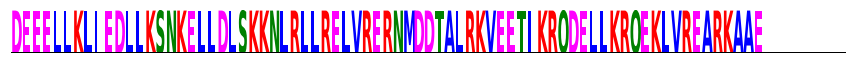

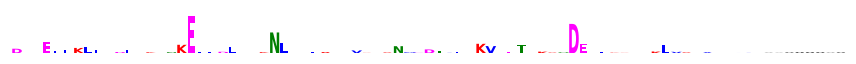

Test sequence 1:


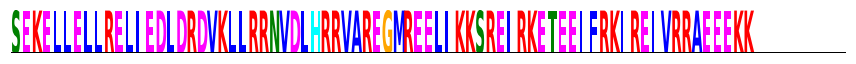

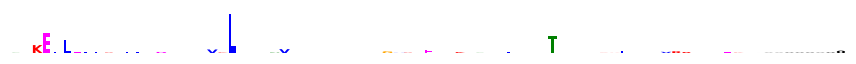

Test sequence 2:


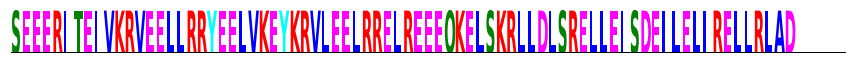

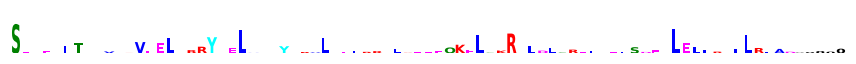

Test sequence 3:


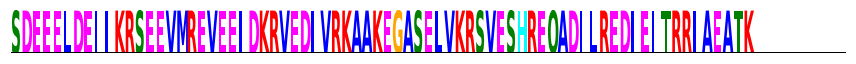

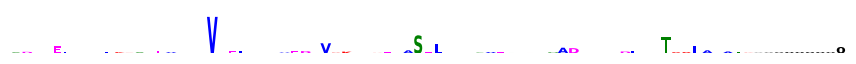

Test sequence 4:


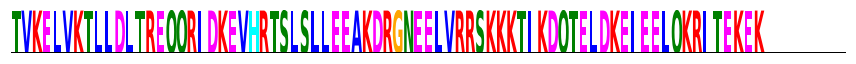

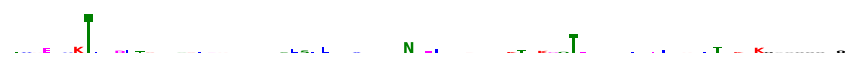

Test sequence 0:


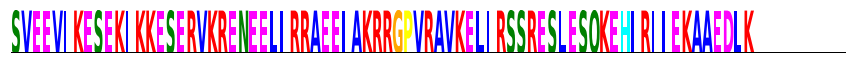

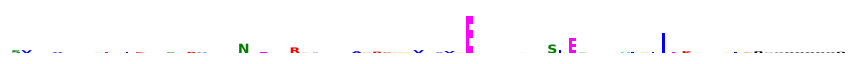

Test sequence 1:


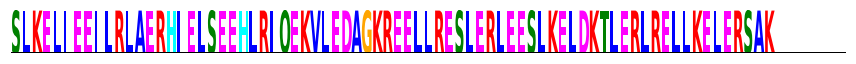

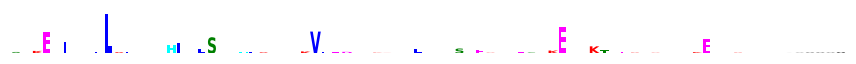

Test sequence 2:


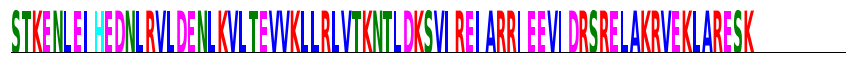

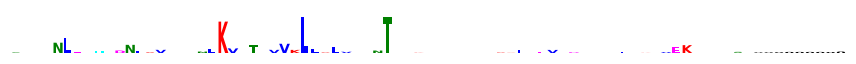

Test sequence 3:


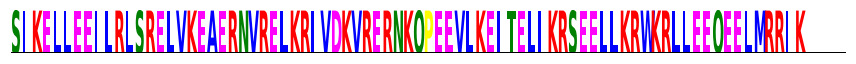

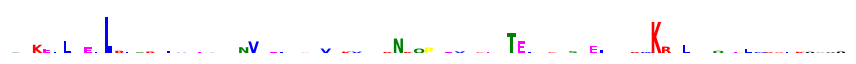

Test sequence 4:


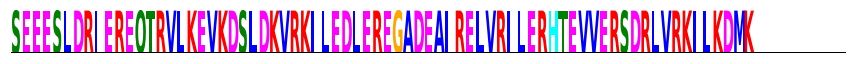

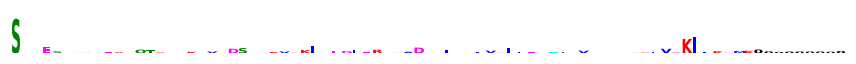

In [20]:
#Visualize importance for binder 1

for plot_i in range(0, 5) :

    print("Test sequence " + str(plot_i) + ":")
    
    sequence_template = sequence_templates[l_1_test[plot_i, 0]]

    plot_protein_logo(residue_map, x_1_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(12, 1), plot_start=0, plot_end=81)
    plot_importance_scores(importance_scores_1_test[plot_i, 0, :, :].T, encoder.decode(x_1_test[plot_i, 0, :, :]), figsize=(12, 1), score_clip=None, sequence_template=sequence_template, plot_start=0, plot_end=81)

#Visualize importance for binder 2

for plot_i in range(0, 5) :

    print("Test sequence " + str(plot_i) + ":")
    
    sequence_template = sequence_templates[l_2_test[plot_i, 0]]

    plot_protein_logo(residue_map, x_2_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(12, 1), plot_start=0, plot_end=81)
    plot_importance_scores(importance_scores_2_test[plot_i, 0, :, :].T, encoder.decode(x_2_test[plot_i, 0, :, :]), figsize=(12, 1), score_clip=None, sequence_template=sequence_template, plot_start=0, plot_end=81)


In [21]:
#Save predicted importance scores

model_name = "invase_" + dataset_name + "_conv" + "_zeropad_no_drop_penalty_005_full_data"

np.save(model_name + "_importance_scores_1_test", importance_scores_1_test)
np.save(model_name + "_importance_scores_2_test", importance_scores_2_test)


In [22]:
#Binder DHD_154

seq_1 = "TAEELLEVHKKSDRVTKEHLRVSEEILKVVEVLTRGEVSSEVLKRVLRKLEELTDKLRRVTEEQRRVVEKLN"[:81]
seq_2 = "DLEDLLRRLRRLVDEQRRLVEELERVSRRLEKAVRDNEDERELARLSREHSDIQDKHDKLAREILEVLKRLLERTE"[:81]

print("Seq 1 = " + seq_1)
print("Seq 2 = " + seq_2)

encoder = IdentityEncoder(81, residue_map)

test_onehot_1 = np.tile(np.expand_dims(np.expand_dims(encoder(seq_1), axis=0), axis=0), (batch_size, 1, 1, 1))
test_onehot_2 = np.tile(np.expand_dims(np.expand_dims(encoder(seq_2), axis=0), axis=0), (batch_size, 1, 1, 1))

test_len_1 = np.tile(np.array([[len(seq_1)]]), (batch_size, 1))
test_len_2 = np.tile(np.array([[len(seq_2)]]), (batch_size, 1))

pred_interacts = predictor.predict(x=[test_onehot_1[:, 0, ...], test_onehot_2[:, 0, ...]])[0, 0]

print("Predicted interaction prob = " + str(round(pred_interacts, 4)))


Seq 1 = TAEELLEVHKKSDRVTKEHLRVSEEILKVVEVLTRGEVSSEVLKRVLRKLEELTDKLRRVTEEQRRVVEKLN
Seq 2 = DLEDLLRRLRRLVDEQRRLVEELERVSRRLEKAVRDNEDERELARLSREHSDIQDKHDKLAREILEVLKRLLERTE
Predicted interaction prob = 0.8533


In [23]:

x_1_test = test_onehot_1[:1]
x_2_test = test_onehot_2[:1]

#Concatenate input binder pairs

x_test = np.concatenate([x_1_test, x_2_test], axis=2)

#Execute INVASE
'''
mask_penalty = 0.05
hidden_dims = 32
n_layers = 4
epochs = 50
batch_size = 128

model_parameters = {
    'lamda': mask_penalty,
    'actor_h_dim': hidden_dims, 
    'critic_h_dim': hidden_dims,
    'n_layer': n_layers,
    'batch_size': batch_size,
    'iteration': int(x_train.shape[0] * epochs / batch_size), 
    'activation': 'relu', 
    'learning_rate': 0.0001
}

invase_model = INVASE(x_train, pred_train, 'invase', model_parameters)

invase_model.train(x_train, pred_train)    
'''
importance_scores_test = invase_model.importance_score(x_test)

importance_scores_1_test, importance_scores_2_test = importance_scores_test[:, :, :seq_length, :], importance_scores_test[:, :, seq_length:, :]


Test sequence 0:


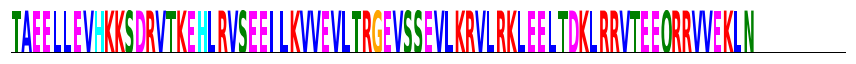

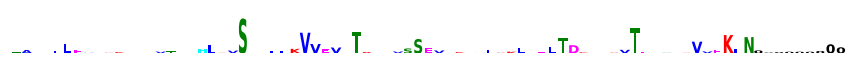

Test sequence 0:


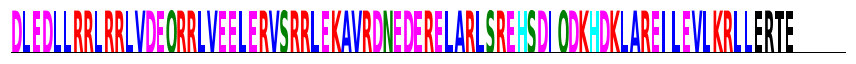

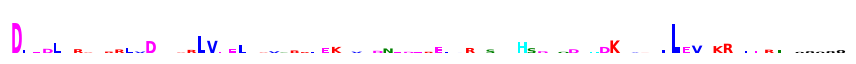

In [24]:

save_figs = True

model_name = "invase_" + dataset_name + "_conv" + "_zeropad_no_drop_penalty_005_full_data"

pair_name = "DHD_154"

#Visualize importance for binder 1

for plot_i in range(0, 1) :

    print("Test sequence " + str(plot_i) + ":")
    
    sequence_template = sequence_templates[l_1_test[plot_i, 0]]

    plot_protein_logo(residue_map, x_1_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(12, 1), plot_start=0, plot_end=81)
    plot_importance_scores(importance_scores_1_test[plot_i, 0, :, :].T, encoder.decode(x_1_test[plot_i, 0, :, :]), figsize=(12, 1), score_clip=None, sequence_template=sequence_template, plot_start=0, plot_end=81, save_figs=save_figs, fig_name=model_name + "_scores_" + pair_name + "_binder_1")

#Visualize importance for binder 2

for plot_i in range(0, 1) :

    print("Test sequence " + str(plot_i) + ":")
    
    sequence_template = sequence_templates[l_2_test[plot_i, 0]]

    plot_protein_logo(residue_map, x_2_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(12, 1), plot_start=0, plot_end=81)
    plot_importance_scores(importance_scores_2_test[plot_i, 0, :, :].T, encoder.decode(x_2_test[plot_i, 0, :, :]), figsize=(12, 1), score_clip=None, sequence_template=sequence_template, plot_start=0, plot_end=81, save_figs=save_figs, fig_name=model_name + "_scores_" + pair_name + "_binder_2")
